# Notebook to look at wbf vs spike rate plots

In particular, worried about the fact that both wbf and spike rate are made kind of artificially continuous (or, for wbf, there's overlap in the STFT). So how to sample time series to capture variation but not be redundant?

## Imports

In [63]:
import os 
import glob
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal

from matplotlib import rcParams
from mosquito.process_abf import load_processed_data
# from mosquito.read_photron import my_read_cih, my_read_mraw

## Params

In [64]:
# # plotting preferences
# plt.style.use('dark_background')
# plt.rc('axes', titlesize=18)     # fontsize of the axes title
# plt.rc('axes', labelsize=16)    # fontsize of the x and y labels

In [65]:
# PLOT PARAMETERS
plot_type = 'paper'  # 'paper' or 'powerpoint'

# # generate a dictionary called fig params that encodes information we care about
if plot_type == 'powerpoint':
    fontsize = 14
    figsize = (10,7.5)
    subplot_left = 0.15
    subplot_right = 0.85
    subplot_top = 0.8
    subplot_bottom = 0.15
elif plot_type == 'paper':
    fontsize = 8
    figsize = (8,8)
    subplot_left = 0.2
    subplot_right = 0.8
    subplot_top = 0.8
    subplot_bottom = 0.2

fig_params = {
      'font.family' : 'sans-serif',
      'font.serif' : 'Times, Palatino, New Century Schoolbook, Bookman, Computer Modern Roman',
      'font.sans-serif' : 'arial, Helvetica, Avant Garde, Computer Modern Sans serif',
      'font.cursive' : 'Zapf Chancery',
      'font.monospace' : 'Courier, Computer Modern Typewriter',
      'font.size' : fontsize,
      'axes.labelsize': fontsize,
      'axes.linewidth': 1.0,
      'xtick.major.width': 1,
      'xtick.minor.width': 1,
      'xtick.labelsize': fontsize,
      'ytick.labelsize': fontsize,
      'figure.figsize': figsize,
}
rcParams.update(fig_params) 

## Load data

In [66]:
# look at example data set first
data_folder = '26_20240524'  # '29_20240530'  # '28_20240529'
axo_num = 1  # 0  # 7  # 8

data = load_processed_data(data_folder, axo_num)


In [67]:
# read out some data
wbf = data['wbf']
t = data['time']
spike_rate = data['spike_rate']
spike_idx = data['spike_idx'] 
flying_idx = data['flying_idx']

window = data['params']['emg_window']
fs = data['sampling_freq']

In [68]:
# x = data['wbf']
# y = data['spike_rate']

# # ----------------------------------------------------
# # ADD THESE 3 LINES TO TAKE ONLY DATA DURING FLIGHT
# flying_idx = data['flying_idx']
# x = x[flying_idx]
# y = y[flying_idx]
# # ----------------------------------------------------

## What does plot look like for fully continuous data?

Text(0.5, 1.0, 'wbf vs burst rate, kernel mult')

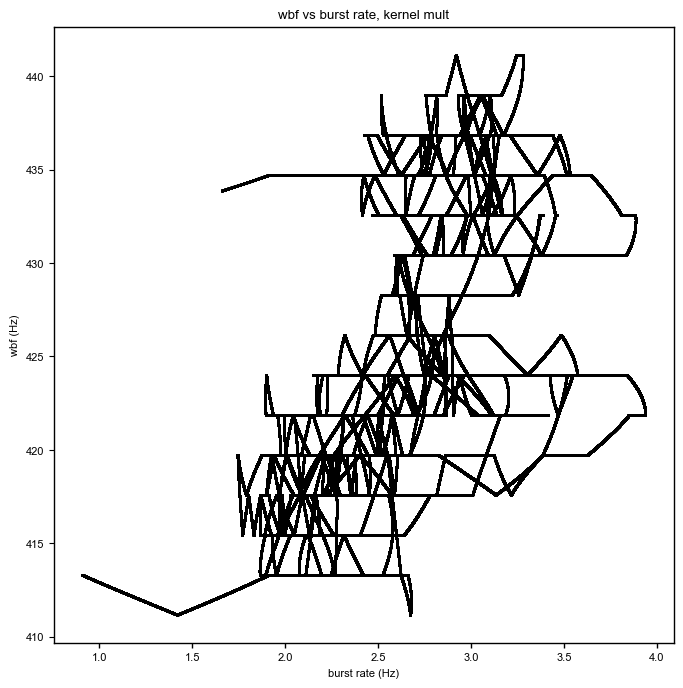

In [69]:
# make initial plot
fig, ax = plt.subplots()

ax.plot(spike_rate[flying_idx], wbf[flying_idx], 'k.', ms=1)

ax.set_xlabel('burst rate (Hz)')
ax.set_ylabel('wbf (Hz)')
ax.set_title('wbf vs burst rate, kernel mult')


Text(0, 0.5, 'wbf (Hz)')

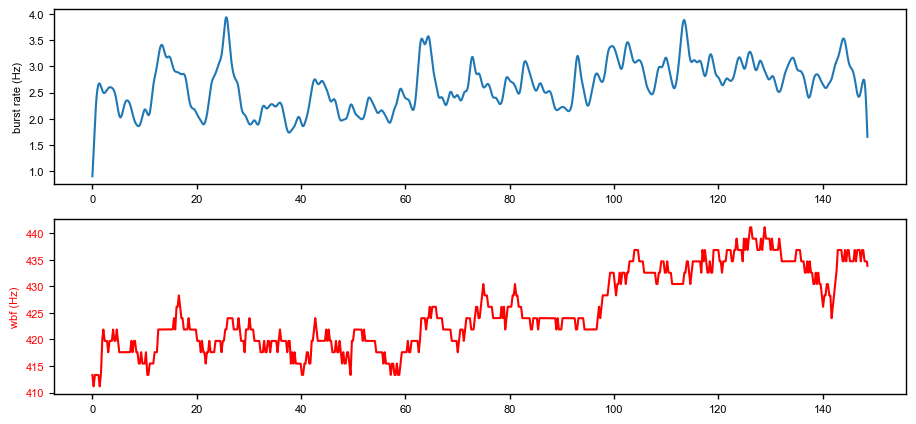

In [70]:
# look at time series plots
# fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(11, 5), sharex=True)
fig, (ax0, ax1) = plt.subplots(2,1,figsize=(11, 5))

ax0.plot(t[flying_idx], spike_rate[flying_idx])
ax0.set_ylabel('burst rate (Hz)') 

#ax1 = ax0.twinx()
color = 'r'
ax1.plot(t[flying_idx], wbf[flying_idx],  color='r')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylabel('wbf (Hz)', color=color) 

In [71]:
mean_isi = np.mean(np.diff(spike_idx))  # guess how big we need gaussian to be
win_std = int(2**np.ceil(np.log2(mean_isi)))
win_n_pts = 8*win_std
win_n_pts

131072

## Try simple binning

In [72]:
# define bin edges
bin_width = 262144/4
bin_edges = np.arange(0, wbf.size, bin_width)
bin_idx = np.digitize(np.arange(wbf.size), bin_edges)


In [83]:
# collect data in bins (use pandas)
try:
    spike_rate_in = np.roll(spike_rate, lags[np.argmax(corr)])
    spike_rate_in = spike_rate_in[flying_idx]
except:
    spike_rate_in = spike_rate[flying_idx]
    
d = {'time': t[flying_idx], 
     'wbf': wbf[flying_idx], 
     'spike_rate': spike_rate_in, 
     'bin_idx': bin_idx[flying_idx]}
df = pd.DataFrame(data=d)

df_binned = df.groupby(['bin_idx']).mean()
# df_binned

In [84]:
# do a linear fit to binned results
m,b = np.polyfit(df_binned['spike_rate'][1:-1],  df_binned['wbf'][1:-1], 1)


In [85]:
1/m

0.0840096706278539

In [86]:
# correlation coefficient
df_binned[['spike_rate', 'wbf']][1:-1].corr()

,spike_rate,wbf
spike_rate,1.000000,0.706412
wbf,0.706412,1.000000


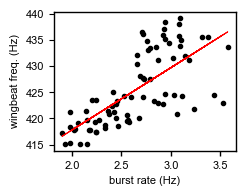

In [89]:
# plot binned results
fig, ax = plt.subplots(figsize=(2.5,2))

ax.plot(df_binned['spike_rate'][1:-1], df_binned['wbf'][1:-1], 'k.') # , 'w.', ms=1, alpha=0.4)
ax.plot(df_binned['spike_rate'][1:-1], m*df_binned['spike_rate'][1:-1] + b, 'r-', lw=0.75)

ax.set_xlabel('burst rate (Hz)')
ax.set_ylabel('wingbeat freq. (Hz)')

fig.tight_layout()
fig.savefig('expr26_axo0001_wbf_vs_burst_rate.png')

In [78]:
print(np.corrcoef(spike_rate, wbf))

[[1.     0.6037]
 [0.6037 1.    ]]


Text(0, 0.5, 'correlation')

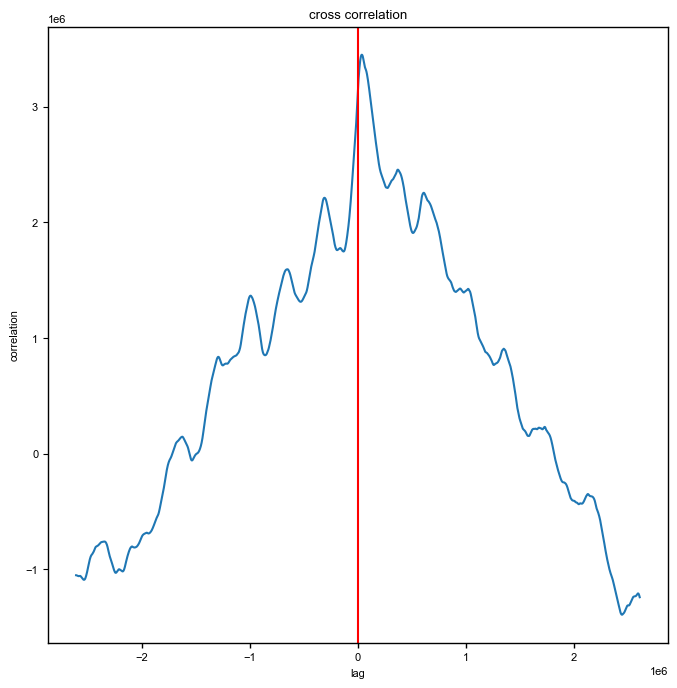

In [79]:
# try cross correlation
#x_tmp = np.linspace(0, 100, 1000)
#sig1 = np.sin(x_tmp)
#sig2 = np.cos(x_tmp)
mode='same'
sig1 = wbf.copy()
sig1 -= np.mean(sig1)
sig1 /= np.std(sig1)
sig2 = spike_rate.copy()
sig2 -= np.mean(sig2)
sig2 /= np.std(sig2)

corr = signal.correlate(sig1, sig2, mode=mode)
lags = signal.correlation_lags(len(sig1), len(sig2), mode=mode)

fig, ax = plt.subplots()

ax.plot(lags, corr)
ax.axvline(0, color='r')

# ax.set_xlim([-2, 2])
ax.set_title('cross correlation')
ax.set_xlabel('lag')
ax.set_ylabel('correlation')

In [80]:
# correlation without shift:
print('correlation without shift ', np.corrcoef(spike_rate[flying_idx], wbf[flying_idx])[0,1])

# correlation with shift:
spike_rate_shifted = np.roll(spike_rate, lags[np.argmax(corr)])
print('correlation with shift ', np.corrcoef(spike_rate_shifted[flying_idx], wbf[flying_idx])[0,1])

correlation without shift  0.603727791340475
correlation with shift  0.6655336986299126


Text(0, 0.5, 'wbf (Hz)')

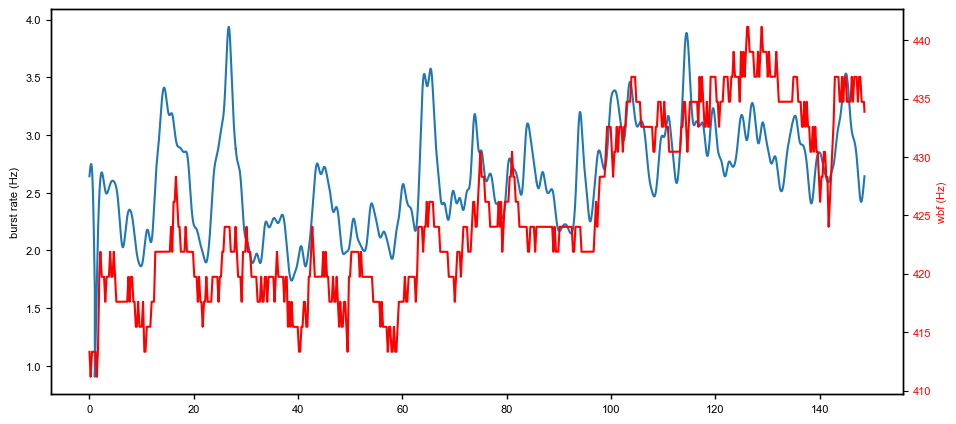

In [81]:
fig, ax0 = plt.subplots(figsize=(11, 5))

ax0.plot(t[flying_idx], np.roll(spike_rate[flying_idx], lags[np.argmax(corr)]))
ax0.set_ylabel('burst rate (Hz)') 

ax1 = ax0.twinx()
color = 'r'
ax1.plot(t[flying_idx], wbf[flying_idx], color='r')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylabel('wbf (Hz)', color=color) 

Text(0.5, 1.0, 'wbf vs burst rate, kernel mult')

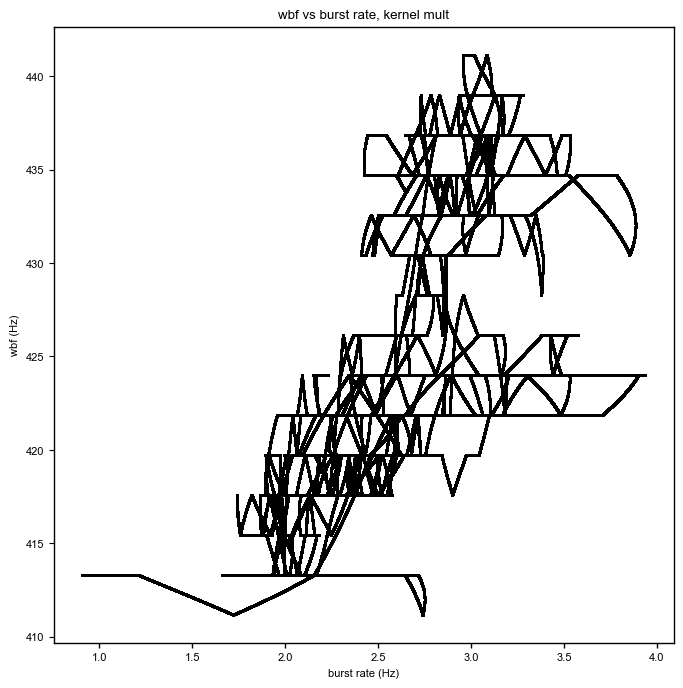

In [82]:
fig, ax = plt.subplots()

ax.plot(np.roll(spike_rate[flying_idx], lags[np.argmax(corr)]), wbf[flying_idx], 'k.', ms=1)

ax.set_xlabel('burst rate (Hz)')
ax.set_ylabel('wbf (Hz)')
ax.set_title('wbf vs burst rate, kernel mult')